# #Multichannel

In [1]:
import os
cwd = os.getcwd()
cwd

'C:\\Users\\ankit\\Documents\\oct5_multichannel'

In [3]:
import xarray as xr
xr.open_dataset("rr.nc")

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 69, time: 480)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2018-12-31
  * latitude   (latitude) float32 5.5 5.75 6.0 6.25 ... 24.75 25.0 25.25 25.5
  * longitude  (longitude) float32 78.5 78.75 79.0 79.25 ... 95.0 95.25 95.5
Data variables:
    e          (time, latitude, longitude) float32 ...
    netflux    (time, latitude, longitude) float64 ...
    somxl010   (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float32 ...
    tau        (time, latitude, longitude) float64 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-02 09:26:14 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [21]:
!conda install -c conda-forge pkg-config

^C


In [18]:
import config
channels = config["e",'netflux','somxl010','tau','sst','tp']
num_channels = len(channels)
ds_path = CONFIG["rr.nc"]
step = int(CONFIG["15"])

TypeError: 'module' object is not subscriptable

In [1]:
import os
import numpy as np
import xarray as xr

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, ConvLSTM2D
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
#channels = CONFIG["FEATURES_NAMES"]
#num_channels = len(channels)
#ds_path = CONFIG["COMBINED_PATH"]
#step = int(CONFIG["N_STEPS"])

def preprocess_data(sequence, n_steps):
	#separating nan and non nan points and doing exp space transform
	undefpts = np.where(sequence!=sequence)
	sequence[undefpts]=-1
	validpts = np.where(sequence>=0)
	T = np.max(sequence[validpts])
	sequence[validpts] = sequence[validpts]/np.max(sequence[validpts]) # bringing all valid points down to 0-1
	#converting to new normalized space (i.e. exponential space) 
	sequence[validpts] = np.exp(sequence[validpts])
	sequence[validpts] = np.power(sequence[validpts],7)
	sequence[undefpts] = 0  # assigning 0 to nan
	
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def create_input(channels, ds_path, n_steps):
	stack = []
	for i in channels:
		input, _ = preprocess_data(xr.open_dataset(ds_path)[i].values, n_steps=n_steps)
		input = np.expand_dims(input, axis=2)
		print(f"Adding channel {i} with shape: {input.shape}")
		stack.append(input)
	out = np.dstack(stack)
	return out
channels=["e",'netflux','tau','sst','tp','somxl010']
ds_path="rr.nc"
step=15
input = create_input(channels, ds_path, step)
_, target = preprocess_data(xr.open_dataset(ds_path)["somxl010"].values, n_steps=step)
target = np.expand_dims(target, axis=1)

assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]

n_rows, n_cols = input.shape[-2], input.shape[-1]

print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)


ValueError: zero-size array to reduction operation maximum which has no identity

In [2]:
seq = keras.Sequential()
seq.add(ConvLSTM2D(filters=4,kernel_size=(3,3),padding='same',input_shape=(None, num_channels, n_rows, n_cols),return_sequences=True,data_format='channels_last'))
#seq.add(TimeDistributed(Conv2DTranspose(filters=20,kernel_size=(3,3),padding='valid',activation='relu')))
seq.add(ConvLSTM2D(filters=8,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
#seq.add(TimeDistributed(Conv2DTranspose(filters=40,kernel_size=(3,3),padding='valid',activation='relu')))
seq.add(ConvLSTM2D(filters=8,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
#seq.add(TimeDistributed(Conv2DTranspose(filters=60,kernel_size=(3,3),padding='valid',activation='relu')))
seq.add(ConvLSTM2D(filters=16,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
seq.add(ConvLSTM2D(filters=16,kernel_size=(3,3),padding='same',return_sequences=False,data_format='channels_last'))
seq.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='same',data_format='channels_last'))
seq.add(Conv2D(filters=1,kernel_size=(3,3),activation='relu',padding='same',data_format='channels_last'))
#seq.add(Conv3DTranspose(filters=1,kernel_size=(1,1,1),activation='relu',padding='valid'))

Adam = optimizers.Adam(learning_rate=10**-4)
seq.compile(loss='mean_squared_error',optimizer=Adam,metrics=['accuracy','mae'])

print(seq.summary())

# Tensor board for visualization
logdir = "/lus/dal/mtechstudent/Lighting/kaustubh/logs/"
tbcallback = callbacks.TensorBoard(log_dir=logdir, histogram_freq=10, write_graph=True)

#Train the model...
nepoch=2

seq.fit(input,target, epochs=nepoch,validation_split=0.3,callbacks=[tbcallback])

seq.save("/lus/dal/mtechstudent/Lighting/kaustubh/logs/4channels.h5")

NameError: name 'num_channels' is not defined

In [5]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt 
import tensorflow as tf

import keras.backend as K
from tensorflow.keras.models import Sequential
from keras.layers import Conv3D, Conv2D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Dropout, Lambda
from keras import optimizers
from keras.layers import Conv2DTranspose,TimeDistributed
from keras import callbacks
import pandas as pd
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam()
'''config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)'''
leadtime=1 # lead timin days
p=leadtime-1

#seqsplit convert data into supervised form after normalization

def seq_split(data,ntrain=480,nsteps=15,nout=1):   # nsteps-- input timesteps # nout---output timesteps
  Tseries = np.array(data.variables['somxl010'])
  #separating nan and non nan points and doing exp space transform
  undefpts = np.where(Tseries!=Tseries)
  Tseries[undefpts]=-1
  validpts = np.where(Tseries>=0)
  T = np.max(Tseries[validpts])
  Tseries[validpts] = Tseries[validpts]/np.max(Tseries[validpts]) # bringing all valid points down to 0-1
  #converting to new normalized space (i.e. exponential space) 
  Tseries[validpts] = np.exp(Tseries[validpts])
  Tseries[validpts] = np.power(Tseries[validpts],7)
  Tseries[undefpts] = 0  # assigning 0 to nan
  
 
  
  L = ntrain
  X = list()
  y = list()
  for i in range(L):
    end_ix = i+nsteps
    if end_ix>(L-1):
      break
    seq_x,seq_y = Tseries[i:end_ix],Tseries[end_ix+p:end_ix+p+nout] # predicts only a future day
    X.append(seq_x)  #input timesteps
    y.append(seq_y)  # output timesteps
  return np.array(X),np.array(y),T
X,y,T = seq_split(ds2)

In [6]:
X[2].shape

(15, 21, 19)

In [7]:
X = X.reshape((X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))
y=np.rollaxis(y,3,1)
y=np.rollaxis(y,3,1)

In [8]:
y.shape

(465, 21, 19, 1)

In [17]:

nan_array = np.isnan(y[380:])
not_nan_array = ~ nan_array
array2 = y[380:][not_nan_array]

In [22]:
X[380].shape

(15, 21, 19, 1)

In [9]:
loaded_model=tf.keras.models.load_model('network.h5')
loaded_model.layers[0].input_shape

(None, None, 21, 19, 1)

In [10]:
prediction=loaded_model.predict(X[380:])
true_value=y[380:]
predicted_value=prediction

In [36]:

np.square(true_value[0].flatten()-predicted_value[0].flatten()).mean()



275956.53

In [39]:
np.corrcoef(true_value.flatten(),predicted_value.flatten())

array([[ 1.       , -0.0572663],
       [-0.0572663,  1.       ]])

In [27]:
true_value[0,0,0]

array([8.041488], dtype=float32)

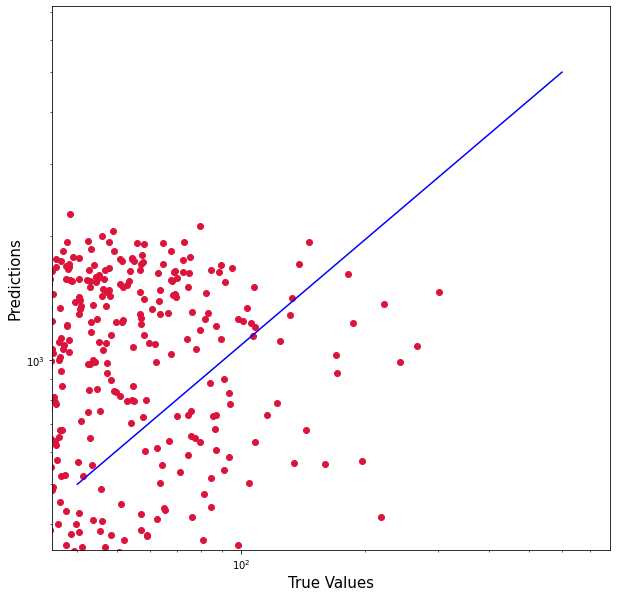

In [24]:

plt.figure(figsize=(10,10))
plt.scatter(true_value, predicted_value, c='crimson')
plt.yscale('log')
plt.xscale('log')

#p1 = max(max(predicted_value), max(true_value)).all()
#p2 = min(min(predicted_value), min(true_value)).all()
plt.plot([600,40], [5000, 500], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [60]:
import scipy
correlation, p_value = stats.pearsonr(x, y)

NameError: name 'stats' is not defined

In [24]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

TypeError: 'NoneType' object is not subscriptable

In [5]:
import xarray as xr
ds2=xr.open_mfdataset("./data/*.nc",combine = 'by_coords', concat_dim="time")
ds2

<xarray.Dataset>
Dimensions:    (latitude: 81, time: 1440, longitude: 69)
Coordinates:
  * latitude   (latitude) float64 5.5 5.75 6.0 6.25 ... 24.75 25.0 25.25 25.5
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-15T12:00:00
  * longitude  (longitude) float32 78.5 78.75 79.0 79.25 ... 95.0 95.25 95.5
Data variables:
    e          (time, latitude, longitude) float32 dask.array<chunksize=(1440, 81, 69), meta=np.ndarray>
    netflux    (time, latitude, longitude) float64 dask.array<chunksize=(1440, 81, 69), meta=np.ndarray>
    somxl010   (time, latitude, longitude) float64 dask.array<chunksize=(1440, 81, 69), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(1440, 81, 69), meta=np.ndarray>
    tau        (time, latitude, longitude) float64 dask.array<chunksize=(1440, 81, 69), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(1440, 81, 69), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-02 09:26:14 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [ ]:
import os
import numpy as np
import xarray as xr

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, ConvLSTM2D
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from config import CONFIG

#os.environ["CUDA_VISIBLE_DEVICES"] = CONFIG["GPU_NUM"]                    # only for apollo server

channels = CONFIG["FEATURES_NAMES"]
num_channels = len(channels)
ds_path = CONFIG["COMBINED_PATH"]
step = int(CONFIG["N_STEPS"])

def preprocess_data(sequence, n_steps):
	#separating nan and non nan points and doing exp space transform
	undefpts = np.where(sequence!=sequence)
	sequence[undefpts]=-1
	validpts = np.where(sequence>=0)
	T = np.max(sequence[validpts])
	sequence[validpts] = sequence[validpts]/np.max(sequence[validpts]) # bringing all valid points down to 0-1
	#converting to new normalized space (i.e. exponential space) 
	sequence[validpts] = np.exp(sequence[validpts])
	sequence[validpts] = np.power(sequence[validpts],7)
	sequence[undefpts] = 0  # assigning 0 to nan
	
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def create_input(channels, ds_path, n_steps):
	stack = []
	for i in channels:
		input, _ = preprocess_data(xr.open_dataset(ds_path)[i].values, n_steps=n_steps)
		input = np.expand_dims(input, axis=2)
		print(f"Adding channel {i} with shape: {input.shape}")
		stack.append(input)
	out = np.dstack(stack)
	return out

input = create_input(channels, ds_path, step)
_, target = preprocess_data(xr.open_dataset(ds_path)["Amplitude"].values, n_steps=step)
target = np.expand_dims(target, axis=1)

assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]

n_rows, n_cols = input.shape[-2], input.shape[-1]

print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

#Defining the model
seq = keras.Sequential()
seq.add(ConvLSTM2D(filters=4,kernel_size=(3,3),padding='same',input_shape=(None, num_channels, n_rows, n_cols),return_sequences=True,data_format='channels_last'))
#seq.add(TimeDistributed(Conv2DTranspose(filters=20,kernel_size=(3,3),padding='valid',activation='relu')))
seq.add(ConvLSTM2D(filters=8,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
#seq.add(TimeDistributed(Conv2DTranspose(filters=40,kernel_size=(3,3),padding='valid',activation='relu')))
seq.add(ConvLSTM2D(filters=8,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
#seq.add(TimeDistributed(Conv2DTranspose(filters=60,kernel_size=(3,3),padding='valid',activation='relu')))
seq.add(ConvLSTM2D(filters=16,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
seq.add(ConvLSTM2D(filters=16,kernel_size=(3,3),padding='same',return_sequences=False,data_format='channels_last'))
seq.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='same',data_format='channels_last'))
seq.add(Conv2D(filters=1,kernel_size=(3,3),activation='relu',padding='same',data_format='channels_last'))
#seq.add(Conv3DTranspose(filters=1,kernel_size=(1,1,1),activation='relu',padding='valid'))

Adam = optimizers.Adam(learning_rate=10**-4)
seq.compile(loss='mean_squared_error',optimizer=Adam,metrics=['accuracy','mae'])

print(seq.summary())

# Tensor board for visualization
logdir = "/lus/dal/mtechstudent/Lighting/kaustubh/logs/"
tbcallback = callbacks.TensorBoard(log_dir=logdir, histogram_freq=10, write_graph=True)

#Train the model...
nepoch=2

seq.fit(input,target, epochs=nepoch,validation_split=0.3,callbacks=[tbcallback])

seq.save("/lus/dal/mtechstudent/Lighting/kaustubh/logs/4channels.h5")

In [11]:
import nctoolkit as nc

data = nc.open_data('mld_nc4.nc')

data.to_latlon(lon = [lon_min, lon_max], lat = [lat_min, lat_max], res = [0.25, 0.25])
data.to_nc("drive/MyDrive/Data/windstress.nc")

AttributeError: module 'nco' has no attribute 'open_data'

In [37]:
#!pip install nctoolkit


In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.models import Sequential
from keras.layers import Conv3D, Conv2D
from keras.layers import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Lambda
from keras import optimizers
from keras.layers import Conv2DTranspose,TimeDistributed
from keras import callbacks
import pandas as pd
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

'''config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)'''

'config = ConfigProto()\nconfig.gpu_options.allow_growth = True\nsession = InteractiveSession(config=config)'

# importing data

In [60]:
import xarray as xr
ds = xr.open_dataset('era5_bob.nc')
df = ds.to_dataframe()
# ds1 = xr.open_dataset('era5_bob.nc')
# df1 = ds1.to_dataframe()

In [40]:
compression_opts = dict(method='zip',
                        archive_name='imd_mld.csv')  
df["sst"].to_csv('imd_mld.zip',
          compression=compression_opts) 

In [48]:
df["sst"]

e     metss     mntss  \
expver latitude longitude time                                       
1      25.0     78.0      1979-01-01 -0.001326 -0.016676 -0.003950   
                          1979-02-01 -0.002057 -0.010233  0.004473   
                          1979-03-01 -0.002111  0.052041 -0.008727   
                          1979-04-01 -0.001810  0.100215 -0.046467   
                          1979-05-01 -0.001656  0.085698 -0.026647   
...                                        ...       ...       ...   
5      5.0      96.0      2021-02-01       NaN       NaN       NaN   
                          2021-03-01       NaN       NaN       NaN   
                          2021-04-01       NaN       NaN       NaN   
                          2021-05-01 -0.003908  0.025016  0.055335   
                          2021-06-01 -0.004216  0.049236  0.125038   

                                           mslhf     msnlwrf     msnswrf  \
expver latitude longitude time                                             
1      25.0     78.0      1979-01-01  -38.370392  -77.272049  140.647278   
                          1979-02-01  -59.544250  -86.958298  177.232819   
                          1979-03-01  -61.090858 -102.092384  217.857361   
                          1979-04-01  -52.378464 -120.411697  243.874374   
                          1979-05-01  -47.929207 -113.433319  244.249756   
...                                          ...         ...         ...   
5      5.0      96.0      2021-02-01         NaN         NaN         NaN   
                          2021-03-01         NaN         NaN         NaN   
                          2021-04-01         NaN         NaN         NaN   
                          2021-05-01 -113.117050  -27.603550  161.289810   
                          2021-06-01 -122.028862  -34.027512  176.157196   

                                          msshf  sst        tp  
expver latitude longitude time                                  
1      25.0     78.0      1979-01-01 -26.951668  NaN  0.000946  
                          1979-02-01 -32.842007  NaN  0.002922  
                          1979-03-01 -48.200043  NaN  0.000292  
                          1979-04-01 -61.389820  NaN  0.000063  
                          1979-05-01 -76.305466  NaN  0.000568  
...                                         ...  ...       ...  
5      5.0      96.0      2021-02-01        NaN  NaN       NaN  
                          2021-03-01        NaN  NaN       NaN  
                          2021-04-01        NaN  NaN       NaN  
                          2021-05-01 -20.872898  NaN  0.008925  
                          2021-06-01 -21.864182  NaN  0.006723  

[6031260 rows x 9 columns]

In [28]:
df.fillna("NAN",inplace=True)
df

somxl010
latitude longitude time                 
5.5      78.0      1979-01-15  24.323135
                   1979-02-15  14.635057
                   1979-03-15   14.12383
                   1979-04-15  20.483715
                   1979-05-15  28.566769
...                                  ...
25.5     96.0      2018-08-15        NAN
                   2018-09-15        NAN
                   2018-10-15        NAN
                   2018-11-15        NAN
                   2018-12-15        NAN

[191520 rows x 1 columns]

In [56]:

imd = Dataset('era5_bob.nc')
imd2=Dataset('sowaflup.nc')

In [8]:
imd2.variables["somxl010"]

<class 'netCDF4._netCDF4.Variable'>
float32 somxl010(time, latitude, longitude)
    _FillValue: 9.96921e+36
    direction: IJL
    ioos_category: Physical Oceanography
    long_name: mixed layer depth 0.01 [m]
    missing_value: 9.96921e+36
unlimited dimensions: 
current shape = (480, 21, 19)
filling off

In [36]:
imd.variables['sst']


<class 'netCDF4._netCDF4.Variable'>
int16 sst(time, expver, latitude, longitude)
    scale_factor: 0.00018888458987265956
    add_offset: 298.96951004989256
    _FillValue: -32767
    missing_value: -32767
    units: K
    long_name: Sea surface temperature
unlimited dimensions: 
current shape = (510, 2, 81, 73)
filling on

In [24]:
  Tseries = np.array(imd.variables['e'])
 Tseries = np.delete(Tseries,0,1)
  Tseries.shape

(510, 0, 81, 73)

In [64]:

#load dataset..

#ds = xr.open_dataset('../Downloads/IMD/.nc')
#df = ds.to_dataframe()

leadtime=1 # lead timin days
p=leadtime-1

#seqsplit convert data into supervised form after normalization

def seq_split(data,ntrain=420,nsteps=15,nout=1):   # nsteps-- input timesteps # nout---output timesteps
  Tseries = df['e'].to_numpy(dtype ='float32')
   
  #separating nan and non nan points and doing exp space transform
  undefpts = np.where(Tseries!=Tseries)
  Tseries[undefpts]=-1
  validpts = np.where(Tseries>=0)
  T = np.max(Tseries[validpts])
  Tseries[validpts] = Tseries[validpts]/np.max(Tseries[validpts]) # bringing all valid points down to 0-1
  #converting to new normalized space (i.e. exponential space) 
  Tseries[validpts] = np.exp(Tseries[validpts])
  Tseries[validpts] = np.power(Tseries[validpts],7)
  Tseries[undefpts] = 0  # assigning 0 to nan
  
 
  
  L = ntrain
  X = list()
  y = list()
  for i in range(L):
    end_ix = i+nsteps
    if end_ix>(L-1):
      break
    seq_x,seq_y = Tseries[i:end_ix],Tseries[end_ix+p:end_ix+p+nout] # predicts only a future day
    X.append(seq_x)  #input timesteps
    y.append(seq_y)  # output timesteps
  return np.array(X),np.array(y),T

# seq = Sequential()
# seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                    input_shape=(None, 21, 19, 1),
#                    padding='same', return_sequences=True))
# seq.add(BatchNormalization())

# seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# seq.add(BatchNormalization())

# seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# seq.add(BatchNormalization())

# seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# seq.add(BatchNormalization())

# seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
#                activation='sigmoid',
#                padding='same', data_format='channels_last'))
# seq.compile(loss='binary_crossentropy', optimizer='adadelta')

#Defining the model

seq = Sequential()
# #--->  1st convLSTM layer <-----
seq.add(ConvLSTM2D(filters=4,kernel_size=(3,3),padding='same',input_shape=(None,21,19,1),return_sequences=True,data_format='channels_last'))
# #---> 2nd convLSTM layer <----
seq.add(ConvLSTM2D(filters=8,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
# #---> 3rd convLSTM layer <---
seq.add(ConvLSTM2D(filters=8,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
# #----> 4th convLSTM layer <---
seq.add(ConvLSTM2D(filters=16,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
# # ---> 5th convLSTM layer <---
seq.add(ConvLSTM2D(filters=16,kernel_size=(3,3),padding='same',return_sequences=False,data_format='channels_last'))
# # ---> final convolution layers <---
seq.add(Conv2D(filters=15,kernel_size=(3,3),activation='relu',padding='same',data_format='channels_last'))
seq.add(Conv2D(filters=1,kernel_size=(3,3),activation='relu',padding='same',data_format='channels_last'))

Adam = optimizers.Adam(lr=10**-4)
seq.compile(loss='mean_squared_error',optimizer=Adam,metrics=['mae'])

# Converting to supervised form

X,y,T = seq_split(imd2)

# The data is processed in channels first format




ValueError: zero-size array to reduction operation maximum which has no identity

In [101]:
# g=[]
# for i in range(len(X)):
#     g=[g,np.array(X[i])]

In [7]:
X = X.reshape((X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))
#X = np.rollaxis(X,4,2)


In [110]:
#y = y.reshape((y.shape[0],y.shape[1],y.shape[2],y.shape[3],1))

In [13]:
# y.shape

(405, 21, 19, 1)

In [12]:
y=np.rollaxis(y,3,1)
y=np.rollaxis(y,3,1)

In [58]:
X.shape

(405, 15, 21, 19)

In [14]:

#X = X.reshape((X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))


#X = np.rollaxis(X,4,2)

nepoch = 5

# Tensor board for visualization 
logdir = '/../IMD/logs'+str(leadtime)
tbcallback = callbacks.TensorBoard(log_dir=logdir, histogram_freq=10, batch_size=8, write_graph=True)

#Train the model...

seq.fit(X[:380],y[:380],epochs=nepoch,validation_split=0.1,batch_size=8,callbacks=[tbcallback])

save_path = './a'+str(leadtime)+'.h5'


seq.save(save_path)


## ---Testing model ---##

mse,mae = seq.evaluate(X[380:],y[380:],batch_size=8)
print("Test metrics:")
print(mse,mae)



Epoch 1/5
 1/43 [..............................] - ETA: 0s - loss: 488264.0312 - mae: 445.8318WARNING:tensorflow:From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
43/43 [==============================] - 28s 652ms/step - loss: 488082.0625 - mae: 445.6884 - val_loss: 487384.6250 - val_mae: 445.1064
Epoch 2/5
43/43 [==============================] - 25s 585ms/step - loss: 484466.7500 - mae: 445.5347 - val_loss: 481417.3125 - val_mae: 446.5045
Epoch 3/5
43/43 [==============================] - 25s 592ms/step - loss: 479355.5625 - mae: 447.0505 - val_loss: 477172.4062 - val_mae: 447.6267
Epoch 4/5
43/43 [==============================] - 26s 605ms/step - loss: 474987.8438 - mae: 448.2310 - val_loss: 472588.5312 - val_mae: 448.9052
Epoch 5/5
4/4 [==============================] - 0

In [15]:
# wide_window = WindowGenerator(
#     input_width=24, label_width=24, shift=1,
#     label_columns=['somxl010'])

# wide_window

NameError: name 'WindowGenerator' is not defined

In [ ]:
# import tensorflow-gpu as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# from tensorflow.python.client import device_lib
# def get_available_devices():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos]
# print(get_available_devices()) 
# # my output was => ['/device:CPU:0']
# good output must be => ['/device:CPU:0', '/device:GPU:0']

In [ ]:
# import xarray as xr

# ds = xr.open_dataset('../../Downloads/IMD/data/imd_data_2.nc')
# df = ds.to_dataframe()